# Stochastic Variational Sparse Heteroscedastic Gaussian Process Regression

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSHGPRegression
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import japanize_matplotlib

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
# x=±πでデータの密度が最大になり、x=0や両端で密度が小さくなるようにする
X = torch.cat([(torch.randn(50) - 3) / 3 * np.pi, (torch.randn(50) + 3) / 3 * np.pi])
# xが大きくなるほど、ノイズが大きくなるようにする
y = X.sin() + torch.randn(100) * (X + 8) / 64

X = X.unsqueeze(1)
y = y.unsqueeze(1)

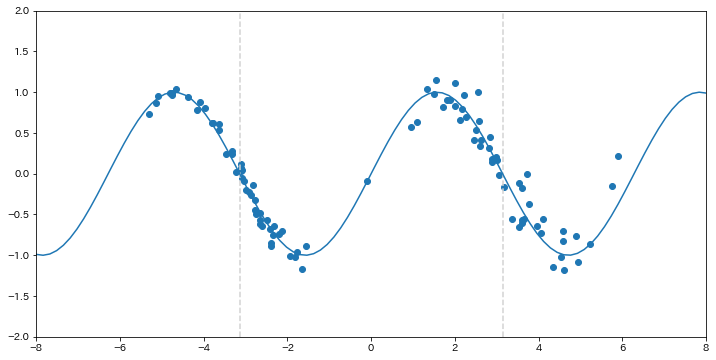

In [7]:
plt.figure(figsize = (12, 6))
plt.axvline(x = -np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
plt.axvline(x = +np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
plt.plot(np.linspace(-8, 8, 100), np.sin(np.linspace(-8, 8, 100)))
plt.scatter(X[:, 0], y[:, 0])
plt.xlim(-8, 8)
plt.ylim(-2, 2)
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

kernel_f = RBF()
kernel_r = RBF()
Z = X[::10, ].clone()
estimator = VSHGPRegression(Z, 1, kernel_f, kernel_r, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    for batch_X, batch_y in dataloader:
        loss = svi.step(batch_X, batch_y, num_data = X.shape[0])
    if epoch % (n_epochs / 10) == 0:
        print(loss)

187.66757683562565
98.40287492637998
24.024656926075636
20.169158272095046
-46.20729957922538
-26.18886327452344
-32.36363627253036
-30.17199772323579
-35.24329304876096
-7.372687365719003


---

## 推論結果

### 予測分布

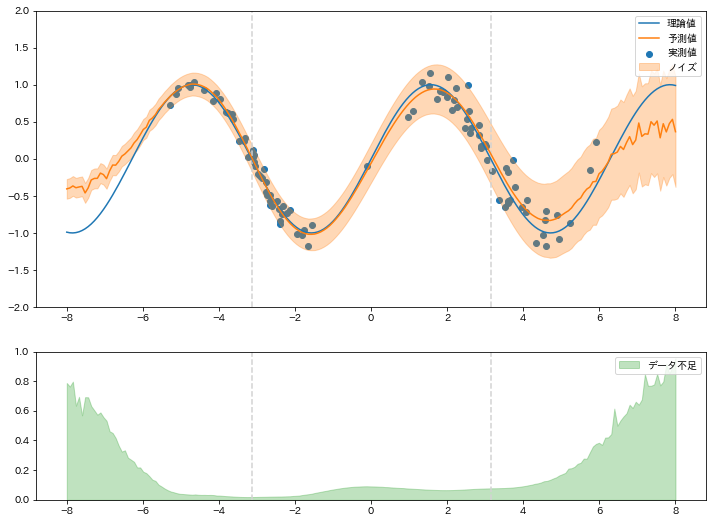

CPU times: user 3.02 s, sys: 284 ms, total: 3.3 s
Wall time: 1.18 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.linspace(-8, 8, 200).unsqueeze(1)
    fnew, rnew = estimator(Xnew, 100)
    fnew_mean = fnew.mean(axis = 0)
    fnew_std = fnew.std(axis = 0)
    rnew_mean = rnew.mean(axis = 0)
    rnew_std = rnew.std(axis = 0)

    fig, axs = plt.subplots(2, 1, figsize = (12, 9), gridspec_kw = {"height_ratios": [2, 1]})

    axs[0].axvline(x = -np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[0].axvline(x = +np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[0].plot(Xnew[:, 0], Xnew.sin()[:, 0], color = "C0", label = "理論値")
    axs[0].scatter(x = X[:, 0], y = y[:, 0], color = "C0", label = "実測値")
    axs[0].plot(Xnew.numpy(), fnew_mean.numpy(), color = "C1", label = "予測値")
    axs[0].fill_between(
        Xnew[:, 0],
        (fnew_mean - 2.0 * rnew_mean)[:, 0],
        (fnew_mean + 2.0 * rnew_mean)[:, 0],
        color = "C1", alpha = 0.3,
        label = "ノイズ"
    )
    axs[0].legend()
    axs[0].set_ylim(-2, 2)

    axs[1].axvline(x = -np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[1].axvline(x = +np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[1].fill_between(
        Xnew[:, 0],
        0,
        fnew_std[:, 0],
        color = "C2", alpha = 0.3,
        label = "データ不足"
    )
    axs[1].legend()
    axs[1].set_ylim(0, 1)

    plt.show()

### ハイパーパラメーター

In [10]:
estimator.gp_f.kernel.scale

tensor(1.9887, grad_fn=<AddBackward0>)

In [11]:
estimator.gp_r.kernel.scale

tensor(10.9728, grad_fn=<AddBackward0>)

In [12]:
estimator.gp_r.likelihood.mu.exp()

tensor([[0.2678]], grad_fn=<ExpBackward>)

### 変分パラメーター

In [13]:
estimator.gp_f.Z

Parameter containing:
tensor([[-2.3004],
        [-3.5709],
        [-0.4067],
        [-3.0840],
        [-5.0980],
        [ 3.9052],
        [ 3.4987],
        [ 1.9422],
        [ 3.0203],
        [ 1.2782]], requires_grad=True)

In [14]:
estimator.gp_f.u_loc

Parameter containing:
tensor([[-0.7667,  1.8631,  1.2397,  0.6820, -0.7401, -0.7467,  1.2243,  1.0034,
          1.2613,  0.5267]], requires_grad=True)

In [15]:
estimator.gp_f.u_cov

tensor([[[ 5.1376e-04, -1.0535e-03, -1.6505e-03, -5.6468e-04,  1.6242e-04,
          -3.1751e-04,  4.2548e-05,  1.7248e-03, -6.0063e-03,  6.7234e-04],
         [-1.0535e-03,  3.4463e-03,  4.7354e-03,  4.6102e-03, -1.4143e-03,
           5.1056e-04,  2.0579e-03, -8.6468e-03,  1.4336e-02, -9.4745e-03],
         [-1.6505e-03,  4.7354e-03,  2.4928e-02,  8.3166e-03, -1.2478e-02,
          -4.9166e-03, -7.1199e-03, -3.6118e-02,  5.5551e-02,  1.4788e-02],
         [-5.6468e-04,  4.6102e-03,  8.3166e-03,  5.1150e-02,  6.7701e-02,
          -2.0607e-02, -6.3430e-03, -6.4927e-02,  2.2317e-02, -1.8375e-02],
         [ 1.6242e-04, -1.4143e-03, -1.2478e-02,  6.7701e-02,  1.5223e-01,
          -2.9543e-02, -1.7223e-02, -6.7306e-02, -9.2775e-04, -4.7549e-03],
         [-3.1751e-04,  5.1056e-04, -4.9166e-03, -2.0607e-02, -2.9543e-02,
           1.5763e-02,  2.5753e-03,  2.7193e-02, -1.7312e-02, -7.0869e-03],
         [ 4.2548e-05,  2.0579e-03, -7.1199e-03, -6.3430e-03, -1.7223e-02,
           2.5753e-

In [16]:
estimator.gp_r.Z

Parameter containing:
tensor([[-1.9787],
        [-3.6922],
        [-1.6030],
        [-2.9344],
        [-4.5709],
        [ 4.9301],
        [ 3.0305],
        [ 2.0700],
        [ 1.4812],
        [ 1.1963]], requires_grad=True)

In [17]:
estimator.gp_r.u_loc

Parameter containing:
tensor([[-0.9614, -1.3221,  0.2272, -0.1663,  0.0620,  0.2681, -0.1262,  0.0133,
         -0.0745, -0.0105]], requires_grad=True)

In [18]:
estimator.gp_r.u_cov

tensor([[[ 0.0107, -0.0105, -0.0189,  0.0086, -0.0060, -0.0047,  0.0040,
           0.0149,  0.0029,  0.0053],
         [-0.0105,  0.1299,  0.2120, -0.1090,  0.0652,  0.0891,  0.0079,
          -0.0118,  0.0154, -0.0123],
         [-0.0189,  0.2120,  0.6663,  0.0067,  0.0671, -0.0937,  0.0040,
          -0.0392,  0.0173, -0.0327],
         [ 0.0086, -0.1090,  0.0067,  0.7870, -0.0459, -0.0436,  0.0437,
          -0.0507, -0.0615, -0.0124],
         [-0.0060,  0.0652,  0.0671, -0.0459,  0.9456,  0.0124, -0.0179,
          -0.0104, -0.1097, -0.0041],
         [-0.0047,  0.0891, -0.0937, -0.0436,  0.0124,  0.6970,  0.0217,
           0.0418,  0.1030,  0.0319],
         [ 0.0040,  0.0079,  0.0040,  0.0437, -0.0179,  0.0217,  1.1114,
          -0.0298,  0.0518,  0.0823],
         [ 0.0149, -0.0118, -0.0392, -0.0507, -0.0104,  0.0418, -0.0298,
           0.8734,  0.0977,  0.0767],
         [ 0.0029,  0.0154,  0.0173, -0.0615, -0.1097,  0.1030,  0.0518,
           0.0977,  1.0254, -0.0859],
 